## Import packges

In [4]:
# Data processing processing
import cv2
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split


# Visualize image
import matplotlib.pyplot as plt
import seaborn as sns

# Model and layers
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, BatchNormalization, Conv2DTranspose, Add, concatenate
from keras.utils.vis_utils import plot_model

# Miscellaneous
import os
from datetime import datetime


## Configuaration

In [5]:
# Directories
WORKING_DIR = os.getcwd()
IMAGES_DIR = os.path.join(WORKING_DIR, 'datasets', 'images')
LABELS_DIR = os.path.join(WORKING_DIR, 'datasets', 'labels')


# Dir paths
TEST_IMG = os.path.join(WORKING_DIR, 'datasets', 'small', 'test_img')
TEST_LABEL = os.path.join(WORKING_DIR, 'datasets', 'small', 'test_labels')

TRAIN_IMG = os.path.join(WORKING_DIR, 'datasets', 'small', 'train_img')
TRAIN_LABEL = os.path.join(WORKING_DIR, 'datasets', 'small', 'train_labels')

CALIB_IMG = os.path.join(WORKING_DIR, 'datasets', 'small', 'calib_img')
CALIB_LABEL = os.path.join(WORKING_DIR, 'datasets', 'small', 'calib_labels')


# Image size
HEIGHT = 128
WIDTH  = 128

# Number of class
NCLASS = 10
LANE_IDS = [1, 2, 3, 4, 5, 6, 7, 8]

# colors for segmented classes\n",
COLORS = [[   50,   60, 100],
          [   0, 255,   0],
          [   0, 255, 255],        
          [ 255,   0,   0],
          [ 255,   0, 255],
          [ 255, 255,   0],
          [ 255, 128,  30],
          [   0, 128,  30]]


EPOCHS = 30
BATCH_SIZE = 4


CLASS_NAMES = ("SWS",
               "SWD",
               "SYS",
               "SYD",
               "DWS",
               "DYS",
               "DYD",
               "DWSD",
               "DWDS",
               "DSWY")

## Utils

In [6]:
# Create dir
def create_dir(path):
    if not os.path.exists(path):
        print("Hi from create dir")
        os.mkdir(path)


In [7]:
# Avoid OOM errors by setting GPU Memory Consumpthion
def set_gpu_growth():
    gpus = tf.config.experimental.list_physical_devices('GPU')
    
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

In [8]:
def unique_counts(seg_img):
    unique, count = np.unique(seg_img, return_counts=True)
    print(np.asarray((unique, count)).T)

In [9]:
# Sort image and label file name         
def load_data(path_img, path_label): 
    """
    Looks for relevant filenames in the shared path 
    Return: two list for original and labeled files respectively
    """
    
    # Read the images folder like a list
    img_list = os.listdir(path_img)
    labels_list = os.listdir(path_label)

    sorted_img_arr = []
    sorted_label_arr = []
    
    for file in img_list:
        sorted_img_arr.append(file)
    for file in labels_list:
        sorted_label_arr.append(file)
    
    sorted_img_arr.sort()
    sorted_label_arr.sort()
    
    return sorted_img_arr, sorted_label_arr

In [10]:
# Read and resize original image
def get_imageArr(path, width, height):
    img = cv2.imread(path, 1)
    img = cv2.resize(img, (width, height))
    return img

In [11]:
# Read and resize seg image
def get_segmentationArr(path, width, height):
    img = cv2.imread(path, 1)
    img = cv2.resize(img, (width, height))
    img = img[: , : , 0]
    return img

In [12]:
# Array of all images 
def all_image_array(org_img_dir, seg_img_dir, list_mapped, width, height):
    X = []
    Y = []

    for i in tqdm(range(len(list_mapped))):
        
        X.append(get_imageArr(os.path.join(org_img_dir, list_mapped[i][0]), width, height))
        Y.append(get_segmentationArr(os.path.join(seg_img_dir, list_mapped[i][1]), width, height))

    return np.array(X), np.array(Y)

In [13]:
def augment_data(train_img_dir, train_seg_dir, list_mapped):
    X = []
    Y = []
    
    for i in tqdm(range(len(list_mapped))):
        
        image = cv2.imread(os.path.join(train_img_dir, list_mapped[i][0]), 1)
        image = tf.image.stateless_random_brightness(image, max_delta=0.2, seed=(1, 2))
        image = tf.image.stateless_random_contrast(image, lower=0.2, upper=0.5, seed=(1, 2))
        image = tf.image.stateless_random_jpeg_quality(image, 75, 95, (1, 2))
        image = tf.image.stateless_random_saturation(image, 0.5, 1.0, (1, 2))
        X.append(image)
        
        label = cv2.imread(os.path.join(train_seg_dir, list_mapped[i][1]), 1)
        label = label[:, :, 0]
        Y.append(label)
        
    return np.array(X), np.array(Y)

In [14]:
# Sperate part of train image as calib image and store the image in directory
def store_train_cal_img(X_train, Y_train, t_img_dir, t_seg_dir, c_img_dir, c_seg_dir):
    trn_count = int(0)
    cal_cnt = int(0)

    for i in tqdm(range(len(X_train))):
        img = X_train[i]
        seg = Y_train[i]
        
        cv2.imwrite(t_img_dir + '/training_' + str(trn_count) + '.png', img)
        cv2.imwrite(t_seg_dir + '/seg_trn_'+ str(trn_count) + '.png', seg)
        
        if ((trn_count%int(8)) == int(0)):
            cv2.imwrite(c_img_dir +  '/calib_'+ str(trn_count) + '.png', img)
            cv2.imwrite(c_seg_dir + '/seg_clb_'+ str(trn_count) + '.png', seg)
            cal_cnt += 1
            
        trn_count += 1

In [15]:
# Store the image after pre-processing
def store_img(X, Y, img_dir, seg_dir, img_name, seg_name):
    count = int(0)
    for i in tqdm(range(len(X))):
        img = X[i]
        seg = Y[i]
        
        cv2.imwrite(img_dir + img_name + str(count) + '.png', img)
        cv2.imwrite(seg_dir + seg_name + str(count) + '.png', seg)
        
        count += 1

In [16]:
def store_aug_img(X, Y, img_dir, seg_dir, img_name, seg_name):
    count = len(X)
    for i in tqdm(range(len(X))):
        img = X[i]
        seg = Y[i]
        
        cv2.imwrite(img_dir + img_name + str(count) + '.png', img)
        cv2.imwrite(seg_dir + seg_name + str(count) + '.png', seg)
        
        count += 1

In [17]:
# Preprocessing data
def preprocess_data(images, masks, target_shape_img, target_shape_mask, path_img, path_mask):
    
    # Pull the relevant dimentions of the image and mask 
    total_img = len(images)
    
    h_img, w_img, c_img = target_shape_img
    h_mask, w_mask, c_mask = target_shape_mask
    
    # Define X and y with number of images along with the shape of one image
    X = np.zeros((total_img, h_img, w_img, c_img), dtype = np.float32)
    y = np.zeros((total_img, h_mask, w_mask, c_mask), dtype = np.int32)
    
    # Resize images and mask
    for file in tqdm(images):
        index = images.index(file)
        path = os.path.join(path_img, file)
        image = cv2.imread(path, 1)
        image = cv2.resize(image, (w_img, h_img))
        image = image/255
        X[index] = image
        
#     for file in mask: 
        # Concert image into an array of desired shape
        mask_index = masks[index]
        path = os.path.join(path_mask, mask_index)
        single_mask = cv2.imread(path, 1)
        single_mask = cv2.resize(single_mask, (w_mask, h_mask))
        single_mask = single_mask[:, :, 0]
        single_mask = single_mask[ : , : , tf.newaxis] # for convinence to start class from 0 (1, 2, 3) -> (0, 1, 2)
        y[index] = single_mask
    return X, y

In [18]:
def give_color_to_seg_img(seg,n_classes):
    if len(seg.shape)==3:
        seg = seg[:,:,0]
    seg_img = np.zeros( (seg.shape[0],seg.shape[1],3) ).astype('float')
    #colors = sns.color_palette("hls", n_classes) #DB
    colors = COLORS #DB
    for c in range(n_classes):
        segc = (seg == c)
        seg_img[:,:,0] += (segc*( colors[c][0]/255.0 ))
        seg_img[:,:,1] += (segc*( colors[c][1]/255.0 ))
        seg_img[:,:,2] += (segc*( colors[c][2]/255.0 ))

    return(seg_img)

In [19]:
# Calculate IoU
def IoU(Yi,y_predi):
    ## mean Intersection over Union
    ## Mean IoU = TP/(FN + TP + FP)
    print("I am in IOU")
    IoUs = []
    Nclass = int(np.max(Yi)) + 1
    #Nclass = cfu.NCLASS
    print("Value of Class: ", Nclass)
    for c in range(Nclass):
        TP = np.sum( (Yi == c)&(y_predi == c))
        FP = np.sum( (Yi != c)&(y_predi == c))
        FN = np.sum( (Yi == c)&(y_predi != c))
        IoU = TP/float(TP + FP + FN)
        #print("class {:02.0f}: #TP={:7.0f}, #FP={:7.0f}, #FN={:7.0f}, IoU={:4.3f}".format(c,TP,FP,FN,IoU))
#        print("class (%2d) %12.12s: #TP=%7.0f, #FP=%7.0f, #FN=%7.0f, IoU=%4.3f" % (c, uce.CLASS_NAMES[c],TP,FP,FN,IoU))
        print("class (%2d) %12.12s: #TP=%7.0f, #FP=%7.0f, #FN=%7.0f, IoU=%4.3f" % (c, CLASS_NAMES[c],TP,FP,FN,IoU))
        print("Value of c: ", c)
        IoUs.append(IoU)
    mIoU = np.mean(IoUs)
    print("_________________")
    print("Mean IoU: {:4.3f}".format(mIoU))
    return

In [20]:
def give_color_to_seg_img(seg):
    n_classes = np.max(seg) + 1
    if len(seg.shape)==3:
        seg = seg[:,:,0]
    seg_img = np.zeros( (seg.shape[0],seg.shape[1],3) ).astype('float')
    # colors = sns.color_palette("hls", n_classes) #DB
    colors = COLORS #DB
    for c in range(n_classes):
        segc = (seg == c)
        # segc = seg
        seg_img[:,:,0] += (segc*( colors[c][0]/255.0 ))
        seg_img[:,:,1] += (segc*( colors[c][1]/255.0 ))
        seg_img[:,:,2] += (segc*( colors[c][2]/255.0 ))
        #np.where(seg_img==0, 128, seg_img)

    return(seg_img)


## U-NET model

## FCN8 Model

In [21]:
# FCN8 model
def fcn8_model(input_shape=(128, 128, 3), n_filter=32, n_class=3):

    i = Input(shape=input_shape)
    ## Block 1
    x = Conv2D(n_filter, (3, 3), activation='relu', padding='same', kernel_initializer = 'HeNormal', name='block1_conv1')(i)
    x = Conv2D(n_filter, (3, 3), activation='relu', padding='same', kernel_initializer = 'HeNormal', name='block1_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)
    f1 = x

    # Block 2
    x = Conv2D(n_filter*2, (3, 3), activation='relu', padding='same', kernel_initializer = 'HeNormal', name='block2_conv1')(x)
    x = Conv2D(n_filter*2, (3, 3), activation='relu', padding='same', kernel_initializer = 'HeNormal', name='block2_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)
    f2 = x

    # Block 3
    x = Conv2D(n_filter*4, (3, 3), activation='relu', padding='same', kernel_initializer = 'HeNormal', name='block3_conv1')(x)
    x = Conv2D(n_filter*4, (3, 3), activation='relu', padding='same', kernel_initializer = 'HeNormal', name='block3_conv2')(x)
    x = Conv2D(n_filter*4, (3, 3), activation='relu', padding='same', kernel_initializer = 'HeNormal', name='block3_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)
    pool3 = x

    # Block 4
    x = Conv2D(n_filter*8, (3, 3), activation='relu', padding='same', kernel_initializer = 'HeNormal', name='block4_conv1')(x)
    x = Conv2D(n_filter*8, (3, 3), activation='relu', padding='same', kernel_initializer = 'HeNormal', name='block4_conv2')(x)
    x = Conv2D(n_filter*8, (3, 3), activation='relu', padding='same', kernel_initializer = 'HeNormal', name='block4_conv3')(x)
    pool4 = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    # Block 5
    x = Conv2D(n_filter*16, (3, 3), activation='relu', padding='same', kernel_initializer = 'HeNormal', name='block5_conv1')(pool4)
    x = Conv2D(n_filter*16, (3, 3), activation='relu', padding='same', kernel_initializer = 'HeNormal', name='block5_conv2')(x)
    x = Conv2D(n_filter*16, (3, 3), activation='relu', padding='same', kernel_initializer = 'HeNormal', name='block5_conv3')(x)
    pool5 = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)

    conv6 = Conv2D(2048 , (7, 7) , activation='relu' , padding='same', kernel_initializer = 'HeNormal', name="conv6")(pool5)
    conv6 = Dropout(0.5)(conv6)
    conv7 = Conv2D(2048 , (1, 1) , activation='relu' , padding='same', kernel_initializer = 'HeNormal', name="conv7")(conv6)
    conv7 = Dropout(0.5)(conv7)

    
    
    pool4_n = Conv2D(n_class, (1, 1), activation='relu', padding='same')(pool4)
    u2 = Conv2DTranspose(n_class, kernel_size=(2, 2), strides=(2, 2), padding='same')(conv7)
    u2_skip = Add()([pool4_n, u2])

    pool3_n = Conv2D(n_class, (1, 1), activation='relu', padding='same')(pool3)
    u4 = Conv2DTranspose(n_class, kernel_size=(2, 2), strides=(2, 2), padding='same')(u2_skip)
    u4_skip = Add()([pool3_n, u4])

    u5 = Conv2DTranspose(n_class, kernel_size=(8, 8), strides=(8, 8), padding='same')(u4_skip)
    o = Conv2D(n_class, 1, activation = 'softmax')(u5)

    model = Model(inputs=i, outputs=o)
    return model


## Data Processing

In [22]:
# Dataset details
print("Training set size: ", len(os.listdir(TRAIN_IMG)))
print("Test set size: ", len(os.listdir(TEST_IMG)))
print("Calibrtion set size: ", len(os.listdir(CALIB_IMG)))

Training set size:  1768
Test set size:  99
Calibrtion set size:  111


In [23]:
target_img_shape = (HEIGHT, WIDTH, 3)
target_label_shape = (HEIGHT, WIDTH, 1)

img_files, label_files = load_data(TRAIN_IMG, TRAIN_LABEL)

# Take sample of every scene

X, y = preprocess_data(img_files, label_files, target_img_shape, target_label_shape, TRAIN_IMG, TRAIN_LABEL)

100%|██████████| 1768/1768 [00:02<00:00, 700.11it/s]


In [24]:
fig, arr = plt.subplots(1, 2, figsize=(16, 10))

arr[0].imshow(X[500])
arr[0].set_title("Road Scene")
arr[1].imshow(y[500])
arr[1].set_title("Ground Truth")
plt.savefig('sample_data.png')

In [44]:
# Split traning data into training and validation set
X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                      test_size=0.10, 
                                                      random_state=42)  
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_valid shape: ", X_valid.shape)
print("y_valid shape: ", y_valid.shape)

X_train shape:  (1591, 128, 128, 3)
y_train shape:  (1591, 128, 128, 1)
X_valid shape:  (177, 128, 128, 3)
y_valid shape:  (177, 128, 128, 1)


# Training

In [45]:
# Set GPU growth 
set_gpu_growth()

In [46]:
# Callbacks - save the best model
model_save_path = os.path.join(os.getcwd(), 'keras_models', 'fcn8',
                               'my_best_model_epoch{epoch:02d}_acc{accuracy:.2f}.h5')

save_callbacks = tf.keras.callbacks.ModelCheckpoint(
    filepath = model_save_path,
    save_best_only=True,
    monitor = 'val_accuracy',
    mode = 'max'
)

In [47]:
# Early stopping
early_stop_callbacks = tf.keras.callbacks.EarlyStopping(
    monitor="loss",
    patience=3
)

### Visualize Model

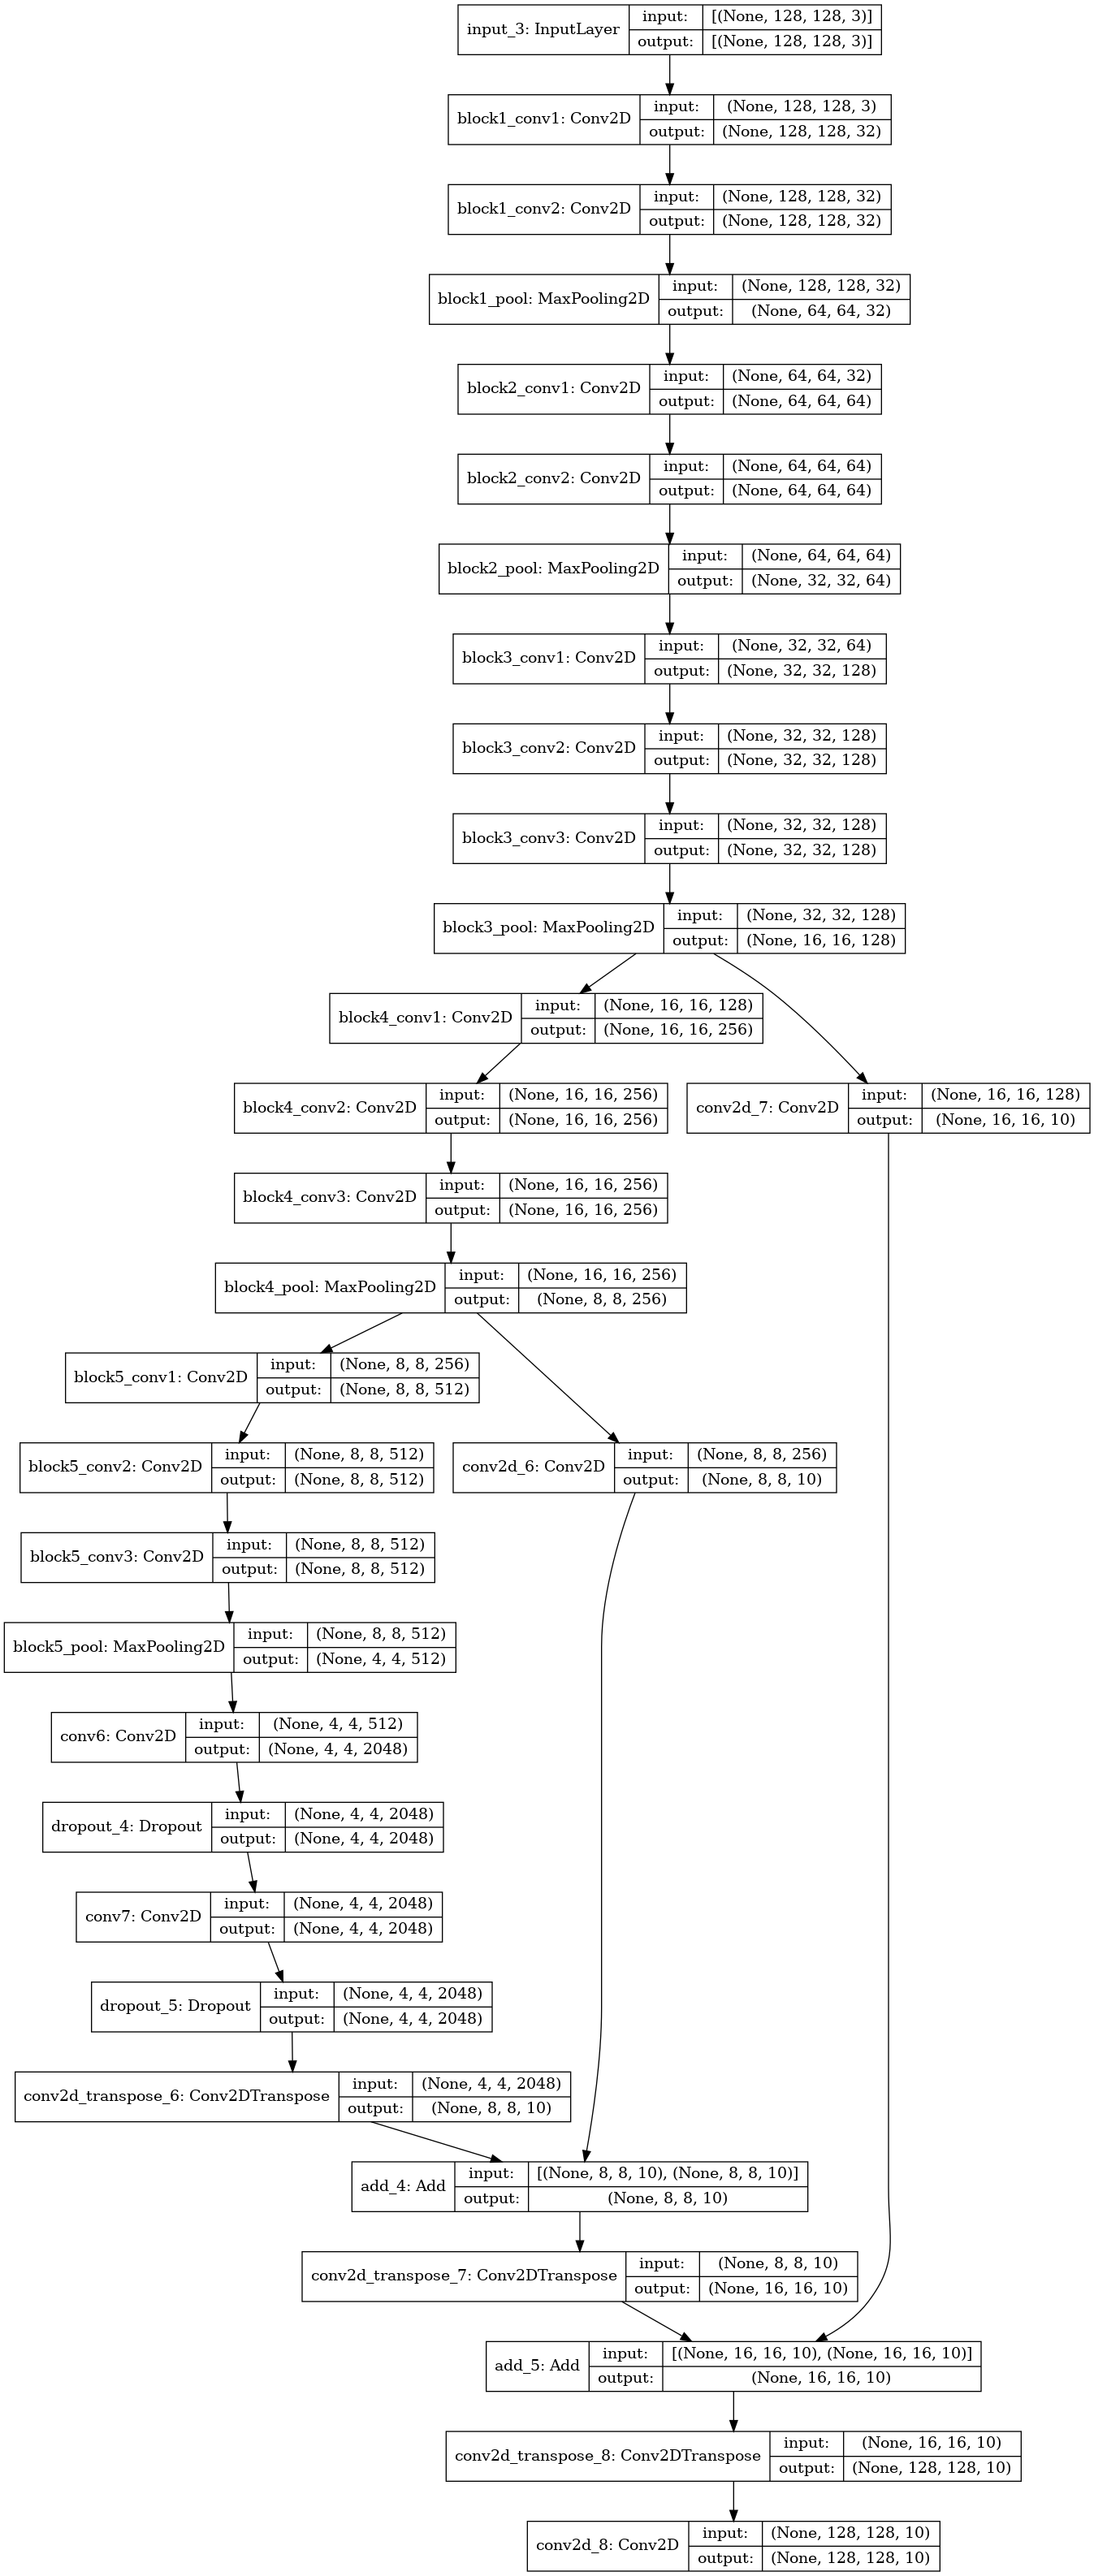

In [55]:
fcn8 = fcn8_model(input_shape=(HEIGHT,WIDTH,3), n_filter=32, n_class=10)
plot_model(fcn8, to_file='fcn8_model_plot.png', show_shapes=True, show_layer_names=True)

### Compile Model

In [56]:
# compile fcn8 model
fcn8.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

### Fit Model

In [57]:
training_unet = False
training_fcn8 = True

In [ ]:
# Training UNET
if training_fcn8:
    fcn8_history = fcn8.fit(X_train, y_train, 
                       batch_size=BATCH_SIZE, 
                       epochs = EPOCHS, 
                       validation_data=(X_valid, y_valid), 
                       callbacks = [save_callbacks, early_stop_callbacks]
                       )

Epoch 1/30


/home/zaman/anaconda3/envs/deepl/lib/python3.8/site-packages/keras/backend.py:4906: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(


398/398 [==============================] - 34s 74ms/step - loss: 1.9599 - accuracy: 0.3695 - val_loss: 1.4110 - val_accuracy: 0.5876


/home/zaman/anaconda3/envs/deepl/lib/python3.8/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/30
398/398 [==============================] - 28s 71ms/step - loss: 0.8759 - accuracy: 0.7586 - val_loss: 0.4375 - val_accuracy: 0.9119
Epoch 3/30
398/398 [==============================] - 28s 71ms/step - loss: 0.3373 - accuracy: 0.9414 - val_loss: 0.2506 - val_accuracy: 0.9616
Epoch 4/30
398/398 [==============================] - 28s 71ms/step - loss: 0.2431 - accuracy: 0.9621 - val_loss: 0.2114 - val_accuracy: 0.9666
Epoch 5/30
398/398 [==============================] - 28s 71ms/step - loss: 0.2106 - accuracy: 0.9652 - val_loss: 0.1909 - val_accuracy: 0.9675
Epoch 6/30
398/398 [==============================] - 28s 72ms/step - loss: 0.1922 - accuracy: 0.9661 - val_loss: 0.1752 - val_accuracy: 0.9680
Epoch 7/30
398/398 [==============================] - 29s 72ms/step - loss: 0.1796 - accuracy: 0.9665 - val_loss: 0.1661 - val_accuracy: 0.9684
Epoch 8/30
398/398 [==============================] - 29s 72ms/step - loss: 0.1706 - accuracy: 0.9667 - val_loss: 0.1588 - val_accuracy:

In [52]:
# Saving final FCN8 model
if training_fcn8:
    unet.save("final_small_fcn8_model.h5")

NameError: name 'unet' is not defined

### Save training History

In [34]:
# Save FCN8 history
if training_fcn8:
    with open('/fcn8_hist', 'wb') as file_pi:
        pickle.dump(fcn8_history.history, file_pi)

### Plot Training History

In [35]:
# Plot FCN8 training
if training_fcn8:
    fig, s_plot = plt.subplots(1, 2, figsize=(20, 5))

    s_plot[0].plot(fcn8_history.history["loss"], color='r', label='train loss')
    s_plot[0].plot(fcn8_history.history["val_loss"], color='b', label='validation loss')
    s_plot[0].set_title('FCN8 Loss Comparison')
    s_plot[0].legend()

    s_plot[1].plot(fcn8_history.history['accuracy'], color='r', label='training accuracy')
    s_plot[1].plot(fcn8_history.history['val_accuracy'], color='b', label='validation accuracy')
    s_plot[1].set_title('FCN8 Accuracy Comparison')
    s_plot[1].legend()
    plt.savefig('fcn8_hist.png')
    plt.show()

# Evaluation

### Plot prediction by two model

### Calculate IoU

In [36]:
target_img_shape = (HEIGHT, WIDTH, 3)
target_label_shape = (HEIGHT, WIDTH, 1)
img_files, label_files = load_data(TEST_IMG, TEST_LABEL)

In [37]:
print(len(img_files))

99


In [38]:
X_test, y_test = preprocess_data(img_files, label_files, target_img_shape, target_label_shape, TEST_IMG, TEST_LABEL)

100%|██████████| 99/99 [00:00<00:00, 293.23it/s]


In [39]:
######################################################################
# Predictions
######################################################################

# Non Quantized Model
model = load_model(os.path.join('keras_models', 'fcn8', 'new_trained_model.h5' ))
nonq_y_pred   = model.predict(X_test, batch_size=1)
print("Shape of Non Quan before argmax ", nonq_y_pred.shape)
nonq_y_pred_i = np.argmax(nonq_y_pred, axis=3)
print("Shape of Non Quan after argmax ", nonq_y_pred_i.shape)


# Ground Truth of test data
y_test_i = np.argmax(y_test, axis=3)

OSError: SavedModel file does not exist at: keras_models/fcn8/new_trained_model.h5/{saved_model.pbtxt|saved_model.pb}

In [ ]:
print("Shape of Non Quan after argmax ", y_test_i.shape)

In [ ]:
print("Shape of y_test", y_test.shape)

In [ ]:
print(np.max(y_test))

In [ ]:
pred = nonq_y_pred_i[...,tf.newaxis]

In [ ]:
unique, counts = np.unique(pred, return_counts=True)
print(np.asarray((unique, counts)).T)

In [ ]:
print(sum(counts))

In [ ]:
np.max(pred)

In [ ]:
pred[0].shape

In [ ]:
np.unique(pred[0])

In [ ]:
IoU(y_test, pred)

In [ ]:
seg = pred[0]

In [ ]:
cv2.imwrite('test_opencv.png', seg)

In [ ]:
plt.figure(figsize=(4,4))
plt.imshow(seg)
plt.savefig('save_pred.png')
plt.show()

In [ ]:
plt.savefig('save_pred.png')

In [ ]:
seg_img = give_color_to_seg_img(seg)

In [ ]:
plt.figure(figsize=(4,4))
plt.imshow(seg_img)
plt.savefig('colored_pred.png')
plt.show()

#cv2.imwrite('cv2_write.jpg', seg_img)

In [ ]:
unique, count = np.unique(seg_img, return_counts=True)
print(np.asarray((unique, count)).T)

In [ ]:
print(np.asarray((unique, count)).T)

In [ ]:
seg_img.shape

In [ ]:
readed_img = cv2.imread('colored_pred.png')

In [ ]:
plt.figure(figsize=(4,4))
plt.imshow(readed_img)
plt.show()

In [ ]:
unique_counts(readed_img)

In [ ]:
fpga_pred = cv2.imread('pred_0.png')

In [ ]:
plt.figure(figsize=(4,4))
plt.imshow(fpga_pred)
#plt.savefig('colored_pred.png')
plt.show()

### Calculate FPS and THROUGHPUT